## Пример для хакатона осеннего семестра первого курса магистратуры "Инженерия машинного обучения"

Чтобы запускать и редактировать код, сохраните копию этого ноутбука себе (Файл->Сохранить копию на диске...). Свою копию вы сможете изменять и запускать.

Не забудьте включить GPU (Среда выполнения->Сменить среду выполнения->Аппаратный ускоритель->GPU)

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
from google.colab import files
%matplotlib inline 

## Загружаем данные

In [ ]:
!wget https://www.dropbox.com/s/9n62h06fc7u2z7a/train.zip?dl=1  -O train.zip

--2023-01-13 12:05:27--  https://www.dropbox.com/s/9n62h06fc7u2z7a/train.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6022:18::a27d:4212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/9n62h06fc7u2z7a/train.zip [following]
--2023-01-13 12:05:27--  https://www.dropbox.com/s/dl/9n62h06fc7u2z7a/train.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc364c98d6095b4b02147b8c5131.dl.dropboxusercontent.com/cd/0/get/B0dG9pz7oEuyIUyTTgeIU1elRWz-tdIG0hCu7blkp-JGo_QPtBUldk0XpCPcIMT5GkOXzEoePVXlffIcJEGYUp86NQpAA6gLAmvpOq5wt52j9FRmUlKDOLbjFTVRKT0Np2B795LIvhq--pS2e6bC-DP_cQ4vtc5VLs8k2zLkXj2rdA/file?dl=1# [following]
--2023-01-13 12:05:28--  https://uc364c98d6095b4b02147b8c5131.dl.dropboxusercontent.com/cd/0/get/B0dG9pz7oEuyIUyTTgeIU1elRWz-tdIG0hCu7blkp-JGo_QPtBUldk0XpCPcIMT5GkOXzEoePVXlffIcJEGY

In [ ]:
!wget https://www.dropbox.com/s/rhwkrnqz5pjyfgv/test.zip?dl=1 -O test.zip

--2023-01-13 12:06:52--  https://www.dropbox.com/s/rhwkrnqz5pjyfgv/test.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/rhwkrnqz5pjyfgv/test.zip [following]
--2023-01-13 12:06:53--  https://www.dropbox.com/s/dl/rhwkrnqz5pjyfgv/test.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc2a594d825d1bbec5c9fec619e3.dl.dropboxusercontent.com/cd/0/get/B0d3kDojd360gRYbJrOEBq3yF3Zab-v-PctIEhRWGXV0FaiRCHgIQzr-cNjbYY8RVAXIXo1iaDn4mOMXjfMT0Kxicmr74cfnXe9bNNkOURI9vIsb123c8DDvLVbRvnmH6uwIdaroQBKErkQfsMfMtBbil3Q2C682PtKOqXQ7vx-g0A/file?dl=1# [following]
--2023-01-13 12:06:53--  https://uc2a594d825d1bbec5c9fec619e3.dl.dropboxusercontent.com/cd/0/get/B0d3kDojd360gRYbJrOEBq3yF3Zab-v-PctIEhRWGXV0FaiRCHgIQzr-cNjbYY8RVAXIXo1iaDn4mOMXjfMT0Kx

In [ ]:
!ls

sample_data  test.zip  train.zip


In [ ]:
!unzip -q train.zip

In [ ]:
!ls train

cat  dog


In [ ]:
!unzip -q test.zip

In [ ]:
!ls test

cat  dog


Смотрим примеры картинок

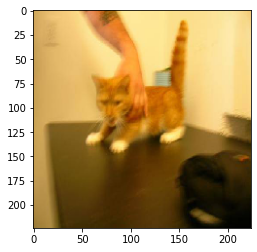

In [ ]:
img_path = 'train/cat/cat.0.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()

## Создаем наборы данных

Набор данных для обучения

In [ ]:
train_dataset = image_dataset_from_directory('train',
                                             batch_size=128,
                                             image_size=(224, 224))

Found 2000 files belonging to 2 classes.


In [ ]:
class_names = train_dataset.class_names

In [ ]:
class_names

['cat', 'dog']

Набор данных для тестирования

In [ ]:
test_dataset = image_dataset_from_directory('test',
                                             batch_size=128,
                                             image_size=(224, 224))

Found 2000 files belonging to 2 classes.


## Создаем составную нейронную сеть

In [ ]:
img_augmentation = Sequential(
    [
        layers.RandomRotation(factor=0.15),
        layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        layers.RandomFlip(),
        layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [ ]:
inputs = layers.Input(shape=(224, 224, 3))
x = img_augmentation(inputs)
model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
# Для задачи с двумя классами изображений
outputs = layers.Dense(1, activation="sigmoid", name="pred")(x)
# Для задачи с несколькими классами изображений
# num_classes = 3 # Задаем количество классов
# outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)
model = tf.keras.Model(inputs, outputs, name="EfficientNet")

16705208/16705208 [==============================] - 2s 0us/step


Компилируем составную нейронную сеть

In [ ]:
# Для задачи с двумя классами изображений
model.compile(loss='binary_crossentropy',
              optimizer='adam', 
              metrics=['accuracy'])
# Для задачи с несколькими классами изображений
# model.compile(loss='categorical_crossentropy',
#              optimizer='adam', 
#              metrics=['accuracy'])

## Обучаем сеть

In [ ]:
history = model.fit(train_dataset,
                    epochs=10)

Epoch 1/10


16/16 [==============================] - 54s 2s/step - loss: 0.4725 - accuracy: 0.7750
Epoch 2/10
16/16 [==============================] - 36s 2s/step - loss: 0.2215 - accuracy: 0.9085
Epoch 3/10
16/16 [==============================] - 36s 2s/step - loss: 0.1820 - accuracy: 0.9190
Epoch 4/10
16/16 [==============================] - 37s 2s/step - loss: 0.1694 - accuracy: 0.9325
Epoch 5/10
16/16 [==============================] - 36s 2s/step - loss: 0.1706 - accuracy: 0.9295
Epoch 6/10
16/16 [==============================] - 36s 2s/step - loss: 0.1436 - accuracy: 0.9465
Epoch 7/10
16/16 [==============================] - 36s 2s/step - loss: 0.1253 - accuracy: 0.9505
Epoch 8/10
16/16 [==============================] - 37s 2s/step - loss: 0.1309 - accuracy: 0.9505
Epoch 9/10
16/16 [==============================] - 36s 2s/step - loss: 0.1158 - accuracy: 0.9535
Epoch 10/10
16/16 [==============================] - 36s 2s/step - loss: 0.1168 - accuracy: 0.9515


Проверяем качество обучения на тестовом наборе данных


In [ ]:
scores = model.evaluate(test_dataset, verbose=1)

16/16 [==============================] - 8s 279ms/step - loss: 0.0569 - accuracy: 0.9870


In [ ]:
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

Доля верных ответов на тестовых данных, в процентах: 98.7


## Использование нейронной сети для распознавания изображений

Вспоминаем номера классов

In [ ]:
class_names

['cat', 'dog']

Загружаем изображение из файла

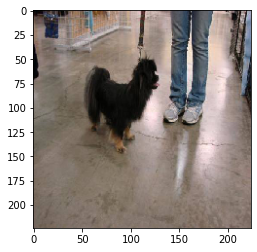

In [ ]:
img_path = 'test/dog/dog.1000.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)
plt.show()

Преобразуем изображение в массив

In [ ]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

Запускаем распознавание

In [ ]:
prediction = model.predict(x)

1/1 [==============================] - 2s 2s/step


Печатаем результаты распознавания

In [ ]:
prediction

array([[0.9814932]], dtype=float32)